<a href="https://colab.research.google.com/github/jacobdwatters/NIOSH-Project/blob/main/SIG_SUB_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [68]:
import numpy as np
from numpy.random import seed
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, balanced_accuracy_score, accuracy_score

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow as tf

import scikitplot as skplt

import scipy as sp
from scipy import stats

import joblib

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
path_after_2010 = '/content/gdrive/My Drive/NIOSH Project/data/violations_processed_after_2010.csv'
violation_data = pd.read_csv(path_after_2010)

In [6]:
FEATURES = ['MINE_TYPE', 'COAL_METAL_IND', 'LIKELIHOOD', 
            'INJ_ILLNESS', 'NO_AFFECTED', 'NEGLIGENCE', 'VIOLATOR_VIOLATION_CNT',
            'VIOLATOR_INSPECTION_DAY_CNT']
TARGETS = ['SIG_SUB']

X = violation_data[FEATURES]
y = violation_data[TARGETS]
y['SIG_SUB'] = y['SIG_SUB'].map({"Y": 1, "N": 0})

<ipython-input-6-113b2d6c4d8c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['SIG_SUB'] = y['SIG_SUB'].map({"Y": 1, "N": 0})


In [7]:
# Define which columns should be encoded vs scaled
columns_to_encode = ['MINE_TYPE', 'COAL_METAL_IND', 'LIKELIHOOD', 'INJ_ILLNESS', 'NEGLIGENCE']
columns_to_scale  = ['VIOLATOR_VIOLATION_CNT', 'NO_AFFECTED', 'VIOLATOR_INSPECTION_DAY_CNT']

# Instantiate encoder/scaler
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False)

# Scale and Encode Separate Columns
scaled_columns  = scaler.fit_transform(X[columns_to_scale])
encoded_columns = ohe.fit_transform(X[columns_to_encode])

# Concatenate (Column-Bind) Processed Columns Back Together
X_pre = np.concatenate([scaled_columns, encoded_columns], axis=1)
np.nan_to_num(X_pre, copy=False)

print('Features shape:', X_pre.shape)

Features shape: (1429135, 22)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_pre, y, test_size = 0.25, random_state = 0)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_train shape:', y_test.shape)

X_train shape: (1071851, 22)
X_test shape: (357284, 22)
y_train shape: (1071851, 1)
y_train shape: (357284, 1)


In [9]:
batch_size = 2**14
epochs = 120

model = keras.Sequential()

model.add(keras.Input(shape = (len(X_train[0]), ) ))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(8, activation="relu"))
model.add(layers.Dense(8, activation="relu"))
model.add(layers.Dense(8, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))


opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss=BinaryCrossentropy(), optimizer=opt)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                    callbacks=[keras.callbacks.EarlyStopping(patience=3)], validation_data=(X_test, y_test))

Epoch 1/120
66/66 [==============================] - 4s 33ms/step - loss: 0.1076 - val_loss: 0.0112
Epoch 2/120
66/66 [==============================] - 3s 49ms/step - loss: 0.0102 - val_loss: 0.0120
Epoch 3/120
66/66 [==============================] - 3s 38ms/step - loss: 0.0102 - val_loss: 0.0101
Epoch 4/120
66/66 [==============================] - 2s 29ms/step - loss: 0.0099 - val_loss: 0.0100
Epoch 5/120
66/66 [==============================] - 2s 30ms/step - loss: 0.0097 - val_loss: 0.0101
Epoch 6/120
66/66 [==============================] - 3s 38ms/step - loss: 0.0098 - val_loss: 0.0100
Epoch 7/120
66/66 [==============================] - 2s 29ms/step - loss: 0.0095 - val_loss: 0.0097
Epoch 8/120
66/66 [==============================] - 3s 43ms/step - loss: 0.0093 - val_loss: 0.0097
Epoch 9/120
66/66 [==============================] - 4s 58ms/step - loss: 0.0096 - val_loss: 0.0098
Epoch 10/120
66/66 [==============================] - 2s 29ms/step - loss: 0.0093 - val_loss: 0.0097

In [42]:
y_prob = model.predict(X_test)
y_pred = y_prob > 0.5
y_probs = np.column_stack([y_prob, 1-y_prob])

11166/11166 [==============================] - 19s 2ms/step


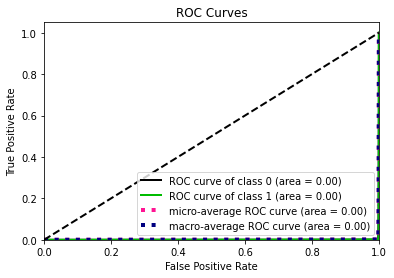

In [49]:
skplt.metrics.plot_roc(y_test.to_numpy().flatten(), y_probs)

In [66]:
accuracy = accuracy_score(y_test, y_pred)
count_sig = sum(y_test.to_numpy()).item()
count_non_sig = len(y_test) - count_sig
print(f'Portion SIG_SUB: {count_sig / len(y_test) * 100:.2f}%')
print(f'Portion non-SIG_SUB: {count_non_sig / len(y_test) * 100:.2f}%')
print(f'Accuracy: {accuracy}')

f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'Precision: {precision}\nRecall: {recall}\nF1: {f1}')

Portion SIG_SUB: 24.01%
Portion non-SIG_SUB: 75.99%
Accuracy: 0.9985837596981673
Precision: 0.996264488199972
Recall: 0.9978437223180567
F1: 0.9970534799217367


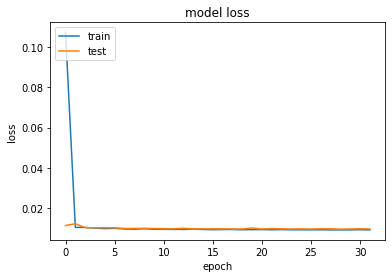

In [65]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()